Taitanic : Machine Learning from Disater


Survived Prediction


The goal : This is a kernel for study. The goal is an accuracy of 0.9

# <a id='0'>Content</a>
- <a href='#1'>Introduction</a>  
- <a href='#2'>Prepare the data analysis</a>  
- <a href='#3'>Data exploration</a>   
 - <a href='#31'>Check the data</a>   
 - <a href='#32'>Density plots of features</a>   
 - <a href='#33'>Distribution of mean and std</a>   
 - <a href='#34'>Distribution of min and max</a>   
  - <a href='#35'>Distribution of skew and kurtosis</a>   
 - <a href='#36'>Features correlations</a>   
 - <a href='#37'>Duplicate values</a>   
- <a href='#4'>Feature engineering</a>
- <a href='#5'>Model</a>
- <a href='#6'>Submission</a>  
- <a href='#7'>References</a>

# <a id='1'>Introduction</a>  
#### **Competition background**
The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

#### **Evaluation**


#### **Timeline**


**Data**

train.csv, test.csv, sample_submission.csv

# <a id='2'>Prepare for data analysis</a>  


## Load packages

In [1]:
import warnings
warnings.filterwarnings('ignore')


import scipy as sp
import pandas as pd
import re

import matplotlib as mlt
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

## Load data   

Let's check what data files are available.

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

# <a id='3'>Data exploration</a>  

## <a id='31'>Check the data</a>  

Let's check the train and test set.

In [3]:
# Data shape
print(train.shape)
print(test.shape)

# Check Columns
print(train.columns)
print(test.columns)

# Column comparison
print(set(train.columns)-set(test.columns))
print(set(test.columns)-set(train.columns))

(891, 12)
(418, 11)
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
{'Survived'}
set()


Train data is approximately twice as large as test data.

Columns are the same except for target variables.

Let's glimpse train and test dataset.

In [4]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [5]:
test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


Train contains:  

* **PassengerId** (string);  
* **Survived**;  
* **2** numerical variables, named **Age** and **Fare**
* **8** categorical variables, named **Pclass**, **Name**, **Sex**, **SibSp**, **Parch**, **Ticket**, **Cabin**, **Embarked**

Test contains:  

* **PassengerId** (string);  
* **2** numerical variables, named **Age** and **Fare**
* **8** categorical variables, named **Pclass**, **Name**, **Sex**, **SibSp**, **Parch**, **Ticket**, **Cabin**, **Embarked**

Let's check if there are any missing data. We will also check the type of data.

We check first train.

In [6]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    types = [str(data[i].dtype) for i in data.columns]
    
    df = pd.DataFrame({'Total':total, 'Precent':percent, 'Types':types})
    
    return(sp.transpose(df))

In [7]:
missing_data(train)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Total,0,0,0,0,0,177,0,0,0,0,687,2
Precent,0,0,0,0,0,19.8653,0,0,0,0,77.1044,0.224467
Types,int64,int64,int64,object,object,float64,int64,int64,object,float64,object,object


In [8]:
missing_data(test)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Total,0,0,0,0,86,0,0,0,1,327,0
Precent,0,0,0,0,20.5742,0,0,0,0.239234,78.2297,0
Types,int64,int64,object,object,float64,int64,int64,object,float64,object,object


In [9]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


뭘 볼 수 있습니다. skew, std, etc...

missing data를 처리를 해보겠습니다.

데이터셋의 통일 성을 위해 train과 test를 합쳐 진행하겠습니다.

In [11]:
Survived = train['Survived']
data = pd.concat([train.drop(columns='Survived'), test])

In [12]:
missing_data(data)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Total,0,0,0,0,263,0,0,0,1,1014,2
Precent,0,0,0,0,20.0917,0,0,0,0.0763942,77.4637,0.152788
Types,int64,int64,object,object,float64,int64,int64,object,float64,object,object


In [13]:
data['Age'].fillna(data['Age'].median(), inplace=True)

In [14]:
data['Fare'].fillna(data['Fare'].median(), inplace=True)

In [15]:
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)

In [16]:
missing_data(data)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Total,0,0,0,0,0,0,0,0,0,1014,0
Precent,0,0,0,0,0,0,0,0,0,77.4637,0
Types,int64,int64,object,object,float64,int64,int64,object,float64,object,object


카빈의 결측치가 너무 많은 것으로 보인다. 결측치가 의미가 있을 지도 모르기 때문에 no value라는 값을 넣어둔다.

In [17]:
data['Cabin'].fillna('no value', inplace=True)

In [18]:
missing_data(data)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Total,0,0,0,0,0,0,0,0,0,0,0
Precent,0,0,0,0,0,0,0,0,0,0,0
Types,int64,int64,object,object,float64,int64,int64,object,float64,object,object


결측치가 정리 되었다.

다시 train, test data로 분리시킨다.

In [19]:
train = data.loc[:train.index[-1]]
test = data.loc[train.index[-1]:][1:]
train = pd.concat([Survived, train], axis=1)

## <a id='32'>Density plots of features</a>  
변수들에 대한 분포를 확인해 봅시다.

먼저 target variable인 Survived에 대해 봅시다

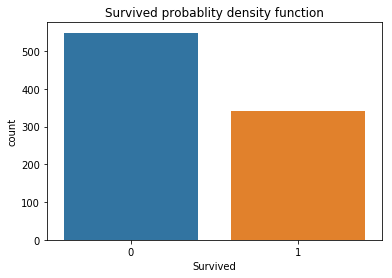

In [20]:
sns.countplot(x='Survived', data=train).set_title('Survived probablity density function')
plt.show()

imbalance 한 데이터인 것을 볼 수 있습니다.

설명변수를 확인해 보겠습니다.

연속형 변수들에 대해 시각화를 하겠습니다.

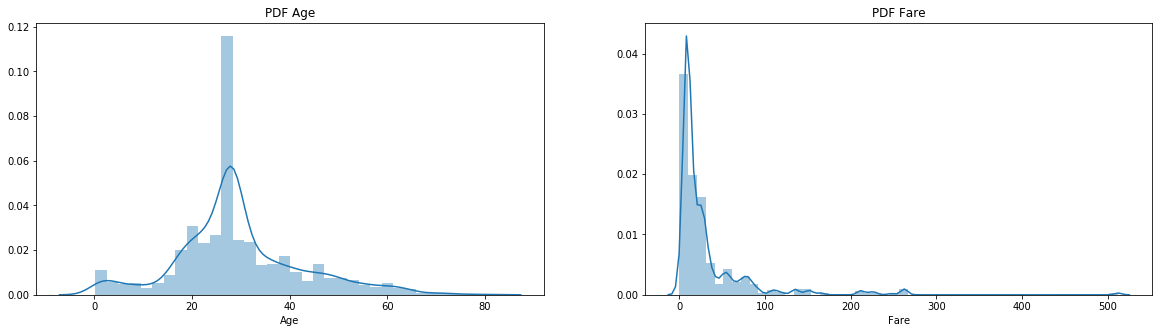

In [21]:
features = ['Age', 'Fare']
nrow=1;ncol=2
f, axes = plt.subplots(nrow, ncol, figsize=(20, 5))
for idx, feature in enumerate(features):
    plt.subplot(nrow, ncol, idx+1)
    sns.distplot(data[feature]).set_title('PDF '+str(feature))
plt.show()

Age의 경우 영유아 쪽에 많은 인원이 분포된 것을 볼 수 있다. 이것은 이상값으로 의심되므로 확인해 보는 게 좋을 것 같다. 25세 이후로는 완만한 곡선형태로 나타나므로 정상적인 곡선을 나타낸다.

Fare의 경우 앞쪽에 매우 치우쳐져 있는 것을 볼수 있고, skew되어 있다. log을 취해 정규성을 띄게 만들어 요금차이에 대한 생존율에 차이가 있는지 알아보는 것도 좋을 듯 하다.

다음은 범주형 변수에 대해 알아보겠습니다.

PassengerId의 경우, 단순 Id값으로 생존율과 관련이 없으므로 생각하지 않겠습니다.

Name, Ticket, Cabin의 경우에는 너무 많은 다 범주 이므로 후에 Feature engineering을 통해 전처리하고 분포를 확인하겠습니다.

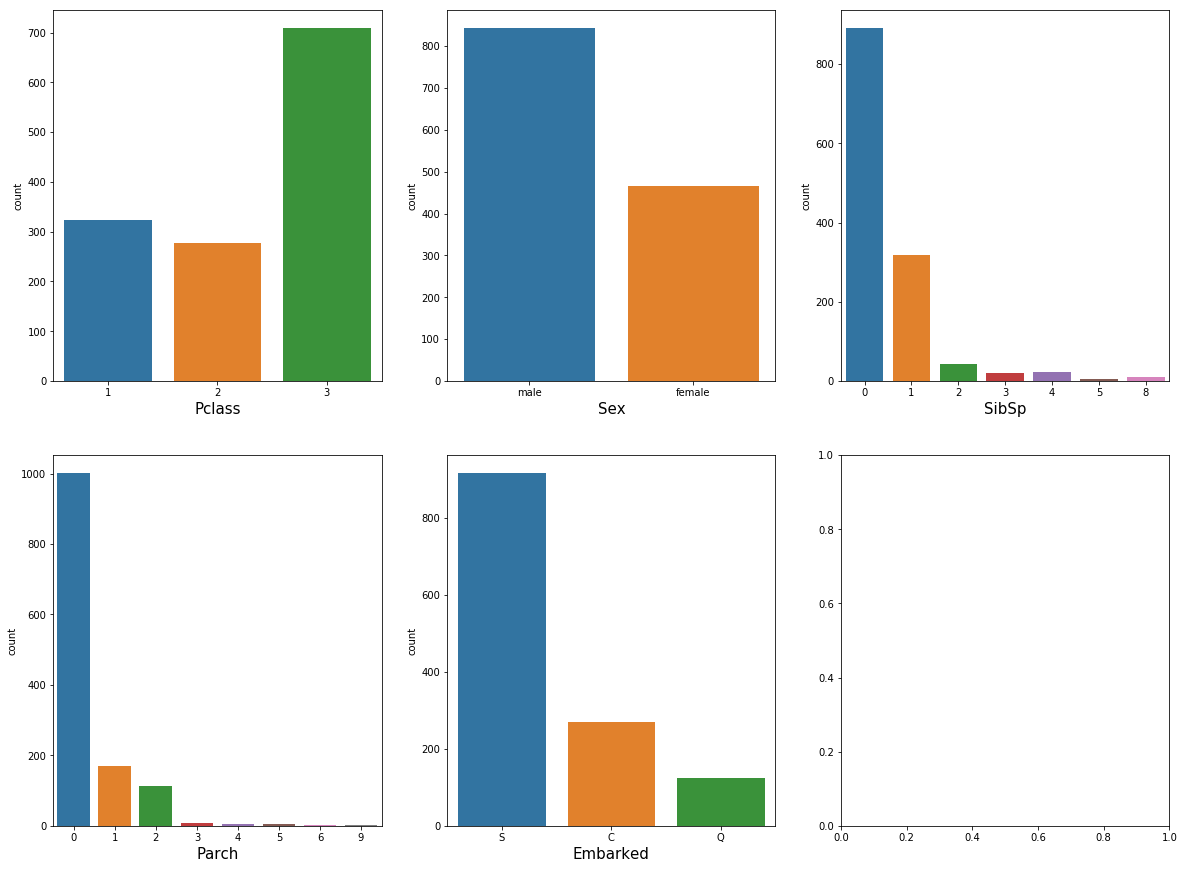

In [22]:
features =  ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked'] # 'Name', 'Ticket', 'Cabin'
nrow=2;ncol=3
f, axes = plt.subplots(nrow, ncol, figsize=(20, 15))
for idx, feature in enumerate(features):
    plt.subplot(nrow, ncol, idx+1)
    sns.countplot(data[feature])
    plt.xlabel(feature, fontsize=15)
#     plt.xticks(rotation=90)
plt.show()

특정 하나의 값이 많은 것을 알 수 있습니다. 이것이 생존율과 관계가 있는 지 유심히 살펴볼 필요가 있습니다.

## <a id='33'>Feature Engineering1</a>  
위에서 다범주로 인해 확인하지 못한 변수들을 확인해 보겟습니다.

범주를 축소해서 확인해 보겠습니다.

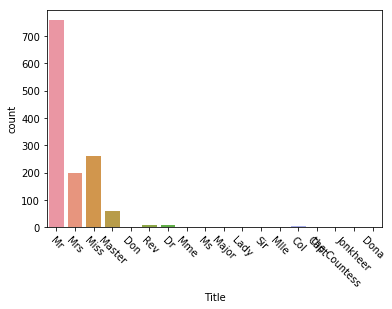

In [23]:
data['Title'] = data['Name'].apply(lambda x: x.split(', ')[1].split('.')[0])
sns.countplot(data['Title'])
plt.xticks(rotation=-45)
plt.show()

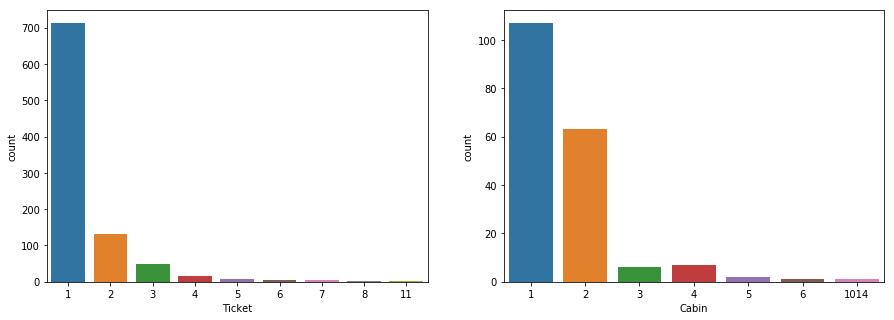

In [24]:
nrow=1;ncol=2
f, axes = plt.subplots(nrow, ncol, figsize=(15, 5))
plt.subplot(nrow, ncol, 1)
sns.countplot(data['Ticket'].value_counts())
plt.subplot(nrow, ncol, 2)
sns.countplot(data['Cabin'].value_counts())
plt.show()

변수끼리의 관계를 보겠습니다.

y가 범주형 이므로 범주-범주, 범주-연속을 보겠습니다.

범주-연속 먼저입니다.

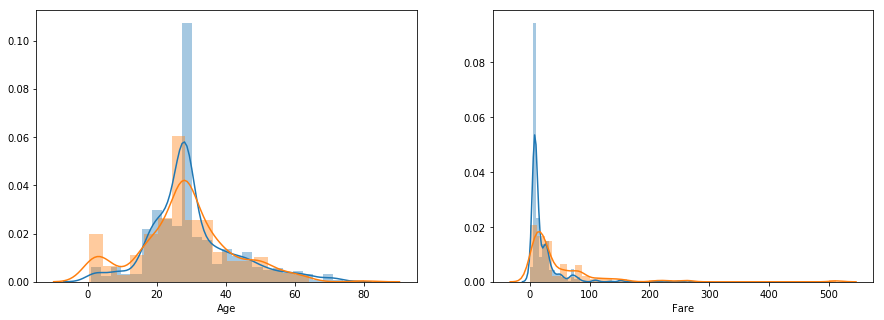

In [25]:
features = ['Age', 'Fare']
nrow = 1;ncol=2
f, axes = plt.subplots(nrow, ncol, figsize=(15, 5))
for indx, feature in enumerate(features):
    plt.subplot(nrow, ncol, indx+1)
    sns.distplot(train.loc[Survived==0, feature])
    sns.distplot(train.loc[Survived==1, feature])
plt.show()

In [28]:
train = data.loc[:train.index[-1]]
test = data.loc[train.index[-1]:][1:]
train = pd.concat([Survived, train], axis=1)

In [32]:
import sklearn

In [33]:
le = sklearn.preprocessing.LabelEncoder()
train['Sex_code'] = le.fit_transform(train['Sex'])
train['Ticket_code'] = le.fit_transform(train['Ticket'])
train['Cabin_code'] = le.fit_transform(train['Cabin'])
train['Embarked_code'] = le.fit_transform(train['Embarked'])
train['Title_code'] = le.fit_transform(train['Title'])

In [34]:
features = ['Survived', 'Pclass', 'Sex_code', 'Age', 'SibSp', 'Parch', 'Ticket_code', 'Fare', 'Cabin_code','Embarked_code', 'Title_code']

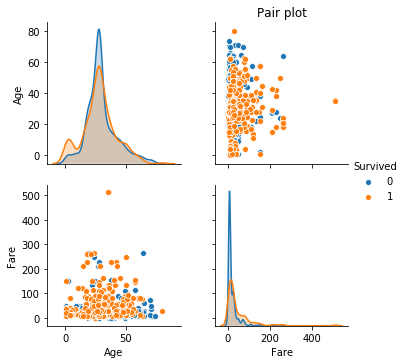

In [35]:
sns.pairplot(train[['Survived', 'Age', 'Fare']], hue='Survived', vars=['Age', 'Fare'])
plt.title('Pair plot')
plt.show()

pari plot으로 퉁쳐버리기~ 변수에 관련된 해석 중요한 것만 잘 봐바라

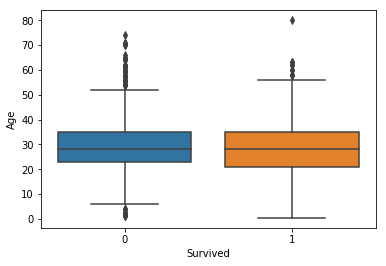

In [36]:
sns.boxplot(x='Survived', y='Age', data=train)

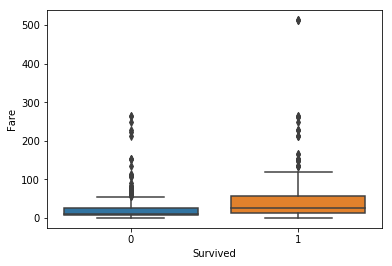

In [37]:
sns.boxplot(x='Survived', y='Fare', data=train)

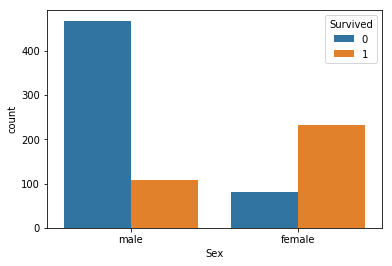

In [38]:
sns.countplot(x='Sex', hue='Survived', data=train)

변수와 변수 사이의 그래프는 y가 범주일 때, 걍 pair plot그리고 싶으면 그리고 box plot이 제일 정석인거 같다. 조정석 같이

이건 y가 연속, x가 범주일 때도 통용되는 이야기 보기 편하고 좀 알 수 있는 게 많다.

violine도 낫배드니 참고바람

범주와 범주는 걍 countplot으로 퉁치는게 제일 나은듯 hue하게


feature engineering and modeling

In [39]:
le = sklearn.preprocessing.LabelEncoder()
data['Sex_code'] = le.fit_transform(data['Sex'])
data['Ticket_code'] = le.fit_transform(data['Ticket'])
data['Cabin_code'] = le.fit_transform(data['Cabin'])
data['Embarked_code'] = le.fit_transform(data['Embarked'])
data['Title_code'] = le.fit_transform(data['Title'])

In [40]:
data = data[['Pclass', 'Age', 'SibSp', 'Parch',
        'Fare', 'Sex_code', 'Ticket_code', 'Cabin_code', 'Embarked_code', 'Title_code']]

In [41]:
train = data.loc[:train.index[-1]]
test = data.loc[train.index[-1]:][1:]
train = pd.concat([Survived, train], axis=1)

In [42]:
train = train[['Survived', 'Age', 'Fare']]
test = test[['Age', 'Fare']]

In [46]:
# import sklearn.linear_model
# help(sklearn.linear_model.LogisticRegression)

In [47]:
model = sklearn.linear_model.LogisticRegression()

In [53]:
# dir(sklearn.model_selection.train_test_split)

In [54]:
trn, val, trn_y, val_y = sklearn.model_selection.train_test_split(train[['Age', 'Fare']], Survived)

In [55]:
model.fit(trn, trn_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [56]:
# predict = model.predict_proba(val)[:,1]
predict = model.predict(val)

In [57]:
sklearn.metrics.accuracy_score(val_y, predict)

0.6367713004484304

In [58]:
sklearn.metrics.f1_score(val_y, predict)

0.2831858407079646

In [59]:
sklearn.metrics.confusion_matrix(val_y, predict)

array([[126,  11],
       [ 70,  16]])

In [60]:
fpr, tpr, threshold = sklearn.metrics.roc_curve(val_y, predict)
roc_auc = sklearn.metrics.auc(fpr, tpr)

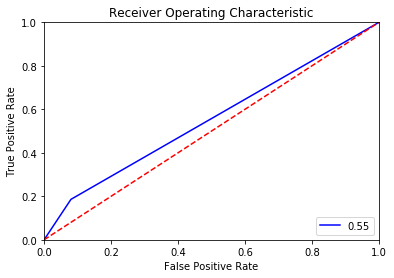

In [61]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = round(roc_auc,2))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [62]:
from sklearn.metrics import classification_report

print(classification_report(val_y, predict, target_names=['Survived', 'Not Survived']))

              precision    recall  f1-score   support

    Survived       0.64      0.92      0.76       137
Not Survived       0.59      0.19      0.28        86

   micro avg       0.64      0.64      0.64       223
   macro avg       0.62      0.55      0.52       223
weighted avg       0.62      0.64      0.57       223



In [63]:
neigh = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)
neigh.fit(trn, trn_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [64]:
predict2 = neigh.predict(val)

In [65]:
print(sklearn.metrics.classification_report(val_y, predict2, target_names=['Survived', 'Not Survived']))

              precision    recall  f1-score   support

    Survived       0.67      0.74      0.71       137
Not Survived       0.51      0.42      0.46        86

   micro avg       0.62      0.62      0.62       223
   macro avg       0.59      0.58      0.58       223
weighted avg       0.61      0.62      0.61       223



In [66]:
predict2 = neigh.predict_proba(val)[:,1]

In [67]:
fpr, tpr, threshold = sklearn.metrics.roc_curve(val_y, predict2)
roc_auc = sklearn.metrics.auc(fpr, tpr)

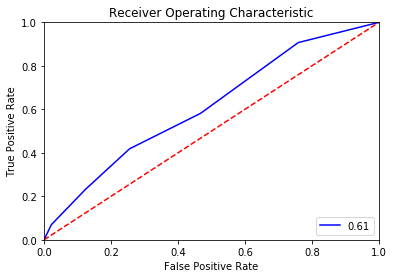

In [68]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = round(roc_auc,2))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [69]:
# help(sklearn.svm.SVC)

clf = sklearn.svm.SVC(random_state=1028, probability=True, kernel='linear')
clf = clf.fit(trn, trn_y)

In [70]:
predict3 = clf.predict(val)

In [71]:
# help(sklearn.metrics.classification_report)
print(sklearn.metrics.classification_report(val_y, predict3, target_names=['O', 'X']))

              precision    recall  f1-score   support

           O       0.64      0.94      0.76       137
           X       0.64      0.16      0.26        86

   micro avg       0.64      0.64      0.64       223
   macro avg       0.64      0.55      0.51       223
weighted avg       0.64      0.64      0.57       223



In [72]:
predict3 = clf.predict_proba(val)[:,1]

In [73]:
fpr, tpr, threshold = sklearn.metrics.roc_curve(val_y, predict3)
roc_auc = sklearn.metrics.auc(fpr, tpr)

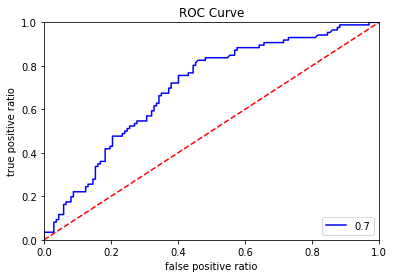

In [74]:
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label=round(roc_auc, 2))
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlabel('false positive ratio')
plt.ylabel('true positive ratio')
plt.xlim([0,1]);plt.ylim([0,1])
plt.show()

In [75]:
# help(sklearn.ensemble.RandomForestClassifier)

clf = sklearn.ensemble.RandomForestClassifier(max_depth=4,
 random_state=1028).fit(trn, trn_y)

In [76]:
predict4 = clf.predict(val)

In [77]:
print(sklearn.metrics.classification_report(val_y, predict4))

              precision    recall  f1-score   support

           0       0.67      0.89      0.77       137
           1       0.64      0.31      0.42        86

   micro avg       0.67      0.67      0.67       223
   macro avg       0.66      0.60      0.59       223
weighted avg       0.66      0.67      0.63       223



In [78]:
predict4 = clf.predict_proba(val)[:,1]

In [79]:
fpr, tpr, threshold = sklearn.metrics.roc_curve(val_y, predict4)
roc_auc = sklearn.metrics.auc(fpr, tpr)

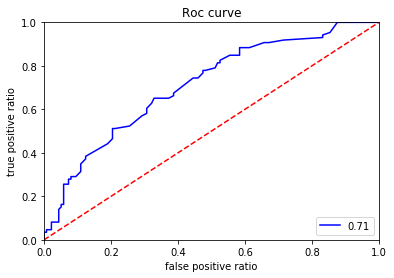

In [80]:
plt.title('Roc curve')
plt.plot(fpr, tpr, 'b', label=round(roc_auc, 2))
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('false positive ratio')
plt.ylabel('true positive ratio')
plt.legend(loc='lower right')
plt.show()

In [88]:
feature_imp = pd.DataFrame(clf.feature_importances_, index=['Age', 'Fare'])

In [110]:
feature_imp = feature_imp[0].sort_values(ascending=False)

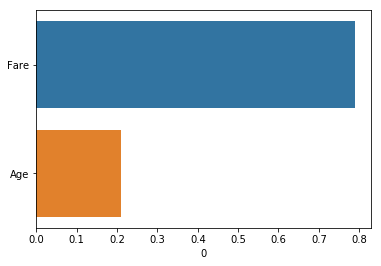

In [111]:
sns.barplot(x=feature_imp, y=feature_imp.index)

In [82]:
feature_imp = pd.Series(clf.feature_importances_,index=['A','B']).sort_values(ascending=False)
feature_imp

B    0.790106
A    0.209894
dtype: float64

In [ ]:
corr = train.corr()
f, axes = plt.subplots(1, 1, figsize=(3, 3))

plt.subplot(1, 1, 1)
sns.heatmap(corr, cmap='coolwarm', square=True, annot=True, fmt='.2f', annot_kws={"size": 12}, linewidths=.05).set_title('heat map_ ')
plt.show()

In [ ]:
help(sns.heatmap)

In [ ]:
corr = train.drop(columns='id').corr(method='spearman')
fig, axes = plt.subplots(1, 1, figsize=(20,12))

hm = sns.heatmap(corr, 
                 ax=axes,           # Axes in which to draw the plot, otherwise use the currently-active Axes.
                 cmap="coolwarm", # Color Map.
                 square=True,    # If True, set the Axes aspect to “equal” so each cell will be square-shaped.
                 annot=True, 
                 fmt='.2f',       # String formatting code to use when adding annotations.
                 annot_kws={"size": 12},
                 linewidths=.05)

fig.subplots_adjust(top=0.93)
fig.suptitle('Spearman Correlation Heatmap', 
              fontsize=14, 
              fontweight='bold')
plt.show()

Missing value fill

In [ ]:
train['Age'] = train['Age'].fillna(round(np.mean(train['Age'])))
train['Cabin'] = train['Cabin'].fillna('no value')
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].value_counts().index[0])

test['Age'] = test['Age'].fillna(round(np.mean(test['Age'])))
test['Fare'] = test['Fare'].fillna(round(np.mean(test['Fare'])))
test['Cabin'] = test['Cabin'].fillna('no value')

In [ ]:
print(train.isnull().sum())
print(test.isnull().sum())

# Y value


In [ ]:
print(train['Survived'].value_counts())
sns.countplot(x='Survived', data=train)

# X value

In [ ]:
train.columns

PassengerId is distinct, so delete

In [ ]:
print(train['PassengerId'].value_counts().value_counts())
print(test['PassengerId'].value_counts().value_counts())

train = train.drop(columns = 'PassengerId')
test = test.drop(columns = 'PassengerId')

Pclass

- 위의 그래프를 보았을 때, Pclass가 1st 일때가 2nd, 3rd보다 생존률이 낮은 것으로 보인다.
- 높은 Pclass일 때, 생존율이 낮다. 왜 그럴까? 이것인 Ticket을 확인할 필요도 보인다.

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(12,5), constrained_layout=True)

sns.countplot(x="Pclass", data=train, hue='Survived', ax=axes[0]).set_title('train countplot')
sns.barplot(x="Pclass", y='Survived', data=train.groupby('Pclass').mean()['Survived'].reset_index(), ax=axes[1]).set_title('train survived_ratio')
sns.countplot(x="Pclass", data=test, ax=axes[2]).set_title('test Pclass')

Name

- 이름은 유니크한 값을 가짐
- 이름의 구조는 first name, title. last name으로 구성되는 것으로 보인다.
- title이 유의미한 값을 가지기에 정규표현식을 사용하여 tilte을 추출한다.
- 또한 이름의 길이가 유의미할까를 생각해 보았다. 이름의 길이가 길 수록 귀족일 확률이 있는 것인가? 혹은 부호일 가능성이 있는지에 대한 궁금증

In [ ]:
print(len(train['Name'])==len(np.unique(train['Name'])))

In [ ]:
# Name length column
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

- Pclass가 Ticket class를 의미하므로, 이름의 길이가 Pclass에 영향을 끼치는 가?(많은 재력을 가지고 있는가)
- Fare 또한 운임비용으로써 재력을 상징할 수 도 있으나, 3rd를 비싼값에 주고 사는 것이 재력가인가를 생각해 보았을 때, 아니다라고 생각했다.

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(12,6), constrained_layout=True)

sns.countplot(x="Name_length", data=train[train['Pclass']==1], ax=axes[0]).set_title('1st')
sns.countplot(x="Name_length", data=train[train['Pclass']==2], ax=axes[1]).set_title('2nd')
sns.countplot(x="Name_length", data=train[train['Pclass']==3], ax=axes[2]).set_title('3rd')

- 대체적으로 1st, 2nd가 3rd보다 우측꼬리가 좀더 두터운 것을 볼 수 있다.

extract title

In [ ]:
train['name_title'] = train['Name'].apply(lambda x: re.search('([A-Za-z]+)\.', x).group(1))
test['name_title'] = test['Name'].apply(lambda x: re.search('([A-Za-z]+)\.', x).group(1))

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(15,5), constrained_layout=True)

a = sns.countplot(x="name_title", data=train, order=train['name_title'].value_counts().index, ax=axes[0])
a.set_xticklabels(labels=train['name_title'].value_counts().index, rotation=45)
a.set_title('train name_title')
sns.countplot(x="name_title", data=test, order=test['name_title'].value_counts().index, ax=axes[1]).set_title('test name_title')

- 겹치지 않는 부분이 있어, 서로 공통으로 가지지 않는 컬럼에 대해 etc로 변환한다.

In [ ]:
train.loc[~train['name_title'].isin(test['name_title']), 'name_title'] = 'etc'
test.loc[~test['name_title'].isin(train['name_title']), 'name_title'] = 'etc'

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(15,5), constrained_layout=True)

sns.countplot(x="name_title", data=train, order=train['name_title'].value_counts().index, ax=axes[0]).set_title('train name_title')
sns.countplot(x="name_title", data=test, order=test['name_title'].value_counts().index, ax=axes[1]).set_title('test name_title')

Sex
- basemodel을 만들어본 결과 강력한 변수 중 하나이다.
- 남성의 경우 죽을 확률이 매우 높고, 여성의 경우 생존확률이 남성보다 높음을 알 수 있다.

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(12,5), constrained_layout=True)

sns.countplot(x="Sex", data=train, hue='Survived', ax=axes[0]).set_title('train countplot')
sns.barplot(x="Sex", y='Survived', data=train.groupby('Sex').mean()['Survived'].reset_index(), order=['male', 'female'], ax=axes[1]).set_title('train Sex_ratio')
sns.countplot(x="Sex", data=test, ax=axes[2]).set_title('test Pclass')

- Interaction effect를 이용하면 어떨까..?

Age

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(8,4), constrained_layout=True)

for val in [0, 1]:
    sns.kdeplot(train.loc[train['Survived']==val, 'Age'], shade=True, label=val, ax=axes[0])

sns.kdeplot(data=test['Age'], shade=True, ax=axes[1])

- 20세 이하인 경우 사망확률이 높은 것을 볼 수 있다. 이 점을 이용하기 위해 연속형 변수 보다는 카테고리컬 변수가 더 효과적인 것으로 보인다.

In [ ]:
train['cate_age'] = pd.cut(train['Age'], [0, 15, 25, 40, 60, np.max(train['Age'])], labels=[1, 2, 3, 4, 5])
test['cate_age'] = pd.cut(test['Age'], [0, 15, 25, 40, 60, np.max(train['Age'])], labels=[1, 2, 3, 4, 5])

- train data를 보았을 때, 약 4개의 봉우리가 보이는데, 그 봉우리를 기준으로 위의 bins기준을 세웠다.

sibsp and parch

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(8,6), constrained_layout=True)

sns.countplot(x='SibSp', data=train, hue='Survived', ax=axes[0])
sns.countplot(x='SibSp', data=test, ax=axes[1])

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(8,6), constrained_layout=True)

sns.countplot(x='Parch', data=train, hue='Survived', ax=axes[0])
sns.countplot(x='Parch', data=test, ax=axes[1])

- sibsp	# of siblings / spouses aboard the Titanic
- parch	# of parents / children aboard the Titanic
- 이므로 두 컬럼은 유사한 성격을 가지고 있다고 볼 수 있다.
- 눈여겨 볼 수 있는 부분은 Parch와 SiSap가 0명일 때, 생존율이 높은 것을 알 수 있다.

In [ ]:
train['family_size'] = train['SibSp'] + train['Parch']
test['family_size'] = test['SibSp'] + test['Parch']

- family_size컬럼의 경우 SibSp와 Parch의 합으로 써 가족의 규모를 뜻한다.

In [ ]:
crosstab_family_size = pd.crosstab(train['Ticket'], train['family_size'])
crosstab_family_size.loc[np.count_nonzero(crosstab_family_size==0, axis=1)!=8, ]

- 티켓번호에 따라 family size가 정해지는 것이 아님을 알 수 있다.
- 그렇다면, family size은 사망률에 영향을 주는가?

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,4), constrained_layout=True)

sns.countplot(x='family_size', data=train, hue='Survived', ax=axes[0])
sns.countplot(x='family_size', data=test, ax=axes[1])

- family_size가 1, 2, 3인경우에 사망률이 높다.
- 그러므로 [0, 4, 5, 6, 7, 10]과 [1, 2, 3]을 그룹핑한다.

In [ ]:
train.loc[train['family_size'].isin([0, 4, 5, 6, 7, 10]), 'family_size'] = 0
train.loc[train['family_size'].isin([1, 2, 3]), 'family_size'] = 1

In [ ]:
test.loc[test['family_size'].isin([0, 4, 5, 6, 7, 10]), 'family_size'] = 0
test.loc[test['family_size'].isin([1, 2, 3]), 'family_size'] = 1

Ticket
- 티켓은 가족이라면 동일한가?
- 티켓이 같을 때 운임비용이 같다면, 가족이라고 판단할 수 있을까

In [ ]:
train.groupby('Ticket').mean()['Fare']

In [ ]:
train[['Ticket', 'Fare']]

조금 더 연구가 필요한 컬럼이다.

In [ ]:
# Ticket length column
train['Ticket_length'] = train['Ticket'].apply(len)
test['Ticket_length'] = test['Ticket'].apply(len)

Cabin

In [ ]:
train['Cabin'].value_counts()

In [ ]:
train['Cabin_first'] = train['Cabin'].apply(lambda x: x[0])
test['Cabin_first'] = test['Cabin'].apply(lambda x: x[0])

- 티켓과 마찬가지로 생각이 더 필요하다.

embarked

fig, axes = plt.subplots(1,3, figsize=(8,6), constrained_layout=True)

sns.countplot(x='Embarked', data=train, hue='Survived', ax=axes[0])
sns.barplot(x='Embarked', y='Survived', data=train.groupby('Embarked').mean()['Survived'].reset_index(), order=['S', 'C', 'Q'], ax=axes[1])
sns.countplot(x='Embarked', data=test, order=['S', 'C', 'Q'], ax=axes[2])

survived ratio

a = train.groupby(['cate_age', 'Pclass', 'Sex']).mean()['Survived']

a = a.fillna(0).reset_index()

a.columns = ['cate_age', 'Pclass', 'Sex', 'est_Survived']

train = pd.merge(train, a, how='left', on=['cate_age', 'Pclass', 'Sex'])
test = pd.merge(test, a, how='left', on=['cate_age', 'Pclass', 'Sex'])

- target column을 이용하여, 파생변수를 생성해보았을 때, 검증셋의 정확도는 올라가나, 테스트셋의 정확도는 감소하는 것을 알 수 있다.

---

# features

features = ['Name_length', 'est_Survived', 'Pclass', 'Sex', 'Embarked', 'na_count', 'name_title', 'cate_age', 'family_size']

train2 = train[features]
test2 = test[features]

# lebeling

label = LabelEncoder()

df = pd.concat([train2, test2])

for i in ['Sex', 'Embarked', 'name_title']:
    df[i] = label.fit_transform(df[i])

train2 = df.iloc[:891, :]
test2 = df.iloc[891:, :]

# one hot encoding

train2 = pd.concat([train['Survived'], train2.iloc[:, :2], pd.get_dummies(train2.iloc[:, 2:].astype(object))], axis=1)

test2 = pd.concat([test2.iloc[:, :2], pd.get_dummies(test2.iloc[:, 2:].astype(object))], axis=1)

# Modeling

## Random Forest

def rf_model(train_val, test_val):
    regr = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=100).fit(
    train_val.drop(columns=['Survived']), train_val['Survived'])
    
    test_val_y = regr.predict(test_val.drop(columns=['Survived'])) > decision_boundary
    test_val_y = test_val_y.astype(int)
    
    true_count = 0
    for i in test_val_y - test_val['Survived']:
        if i == 0:
            true_count+=1
    
    return true_count/len(test_val_y)

# 5-fold

cv = KFold(5, shuffle=True, random_state=0)

for j in range(2, 9):
    for k in range(30, 51):
        L = []
        for i, (idx_train, idx_test) in enumerate(cv.split(train2)):
            train_val = train2.iloc[idx_train]
            test_val = train2.iloc[idx_test]
            
            max_depth=j
            decision_boundary=k/100
            
            L.append(rf_model(train_val, test_val))
            if np.mean(L) > .83:
                print('accuacy : {}, max_depth : {}, decision boundary : {}'.format(np.mean(L), j, k/100))


## Xgboost

## 5-fold CV

cv = KFold(5, shuffle=True, random_state=0)
L = []
for i, (idx_train, idx_test) in enumerate(cv.split(train)):
    train_val = train.iloc[idx_train]
    test_val = train.iloc[idx_test]

    L.append(xgb_model(train_val, test_val))
    
print(np.mean(L)) 

## Save Submission

### Random Forest

regr = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=100).fit(
    train2[test2.columns], train2['Survived'])
test_y = regr.predict(test2)
test_y = test_y > .5
predictions = test_y.astype(int)
test_PassengerId = pd.read_csv('../input/gender_submission.csv')['PassengerId']
submission = pd.concat([pd.DataFrame(test_PassengerId), pd.DataFrame({'Survived':predictions})], axis=1)
submission.to_csv("submission_rf4.csv", index=False)

### Xgboost

### ensembles